# Unsupervised clustering with a SOM

The [Kohonen self-organizing map](https://en.wikipedia.org/wiki/Self-organizing_map) is an unsupervised neural network for clustering data without labels.

First we'll import some data. I'm using an extract from the Rock Property Catalog, https://subsurfwiki.org/wiki/Rock_Property_Catalog

In [44]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/RPC_4_lithologies.csv')

df.head()

,RPC,Description,Lithology,Vp,Vs,Rho,Rho_n
0,104818,KIAMICHI FORMA. 4,sandstone,3045.6,1595.7,2108.0,2109.120585
1,104893,KIAMICHI REMOLD 3,sandstone,3000.6,1517.1,2126.0,2090.342013
2,104652,NAVAJO ARCO 2,sandstone,3363.6,2041.5,2162.0,2131.989982
3,104752,NAVAJO ARCO REMOL 1,sandstone,3195.3,1606.2,2160.0,2184.939233
4,104598,FERRON 82-3 1677.5,sandstone,4237.5,2448.6,2428.0,2472.230768


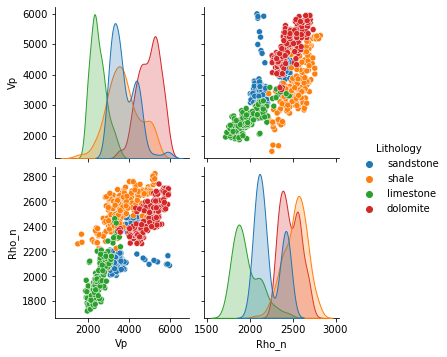

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['Vp', 'Rho_n']

sns.pairplot(df.dropna(), vars=features, hue='Lithology')

In [109]:
df = df.dropna()

In [110]:
X = df[features].values
y = df.Lithology.values

In [111]:
X

array([[3045.6       , 2109.12058533],
       [3000.6       , 2090.34201313],
       [3363.6       , 2131.98998202],
       ...,
       [5446.19      , 2521.125328  ],
       [5347.77      , 2470.80647531],
       [5347.77      , 2549.15824072]])

## Clustering with SOM

### Instructor: briefly explain what an SOM does

In [112]:
from sklearn_som.som import SOM

In [115]:
som = SOM(m=2, n=2, dim=2, lr=1, sigma=1, max_iter=10000)
som.fit(X)

In [116]:
df['SOM'] = som.predict(X)

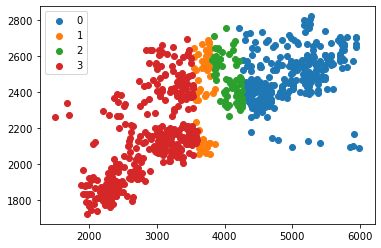

In [117]:
for name, group in df.groupby('SOM'):
    plt.scatter(group.Vp, group.Rho_n, label=name)
plt.legend()

## Plot the decision boundary

We can visualize the decision boundary, and the class 'regions' using a small function in `utils.py`:

```python
def decision_regions(clf, X_val, y_val, extent, step=1):
    """
    Generate the decision surface of a classifier.
    """
    y_pred = clf.predict(X_val)
    x_min, x_max, y_min, y_max = extent
    try:
        x_step, y_step = step
    except TypeError:
        x_step = y_step = step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, x_step),
                         np.arange(y_min, y_max, y_step))
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    return y_pred, Z.reshape(xx.shape + (-1,))
```

In [118]:
import numpy as np

def decision_regions(clf, X_val, y_val, extent, step=1):
    """
    Generate the decision surface of a classifier.
    """
    y_pred = clf.predict(X_val)
    x_min, x_max, y_min, y_max = extent
    try:
        x_step, y_step = step
    except TypeError:
        x_step = y_step = step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, x_step),
                         np.arange(y_min, y_max, y_step))
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    return y_pred, Z.reshape(xx.shape + (-1,))


Build up from this:

In [119]:
# from utils import decision_regions

extent = [1400, 6500, 1900, 2900]
y_pred, y_all = decision_regions(som, X, y, extent, step=2)
    
plt.figure(figsize=(15, 9))
plt.imshow(y_all, extent=extent, origin='lower', aspect='auto')
plt.colorbar()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

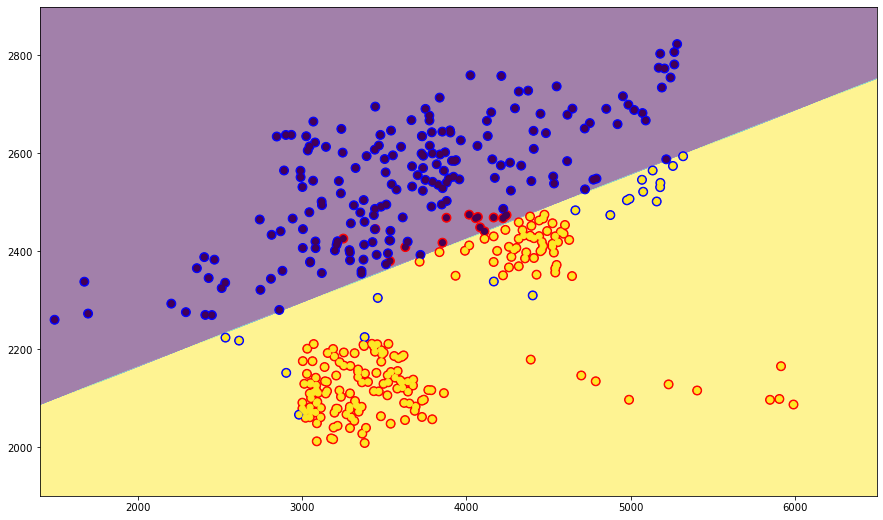

In [10]:
plt.figure(figsize=(15, 9))
plt.imshow(y_all <= 0.0, extent=extent, origin='lower', aspect='auto', alpha=0.5)
plt.scatter(*X.T, c=is_sand(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_sand(y_pred))
plt.show()

## A non-linear SVM model

If we employ the **kernel trick** we can fit a nonlinear model. Scikit-learn's `SVC` actually uses this by default:

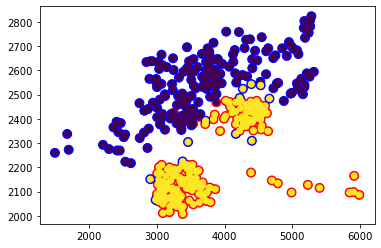

In [11]:
from sklearn.svm import SVC

svc = SVC()  # Default is kernel='rbf'

svc.fit(X, y)

y_pred = svc.predict(X)

plt.scatter(*X.T, c=is_sand(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_sand(y_pred))

The score is better:

In [ ]:
accuracy_score(y, y_pred)

In [ ]:
y_pred, y_all = decision_regions(svc, X, y, extent, step=2)
    
plt.figure(figsize=(15, 9))
plt.imshow(y_all <= 0.0, extent=extent, origin='lower', aspect='auto', alpha=0.5)
plt.scatter(*X.T, c=is_sand(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_sand(y_pred))
plt.show()

## Validation

We should not train the model, then check its accuracy only on that dataset. It's cheating.

Let's hold out some validation data, or 'blind' data.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

Now let's train a model *on only the training data* and validate it properly.

In [ ]:
svc = SVC().fit(X_train, y_train)

y_pred = svc.predict(X_val)

accuracy_score(y_val, y_pred)

## Standardize the data

Note that it's a good idea to train SVMs on the Z-scores of your data, i.e. zero mean, StdDev = 1. This ensures that the different scales of the features is not causing a problem. (They are about the same scale in our dataset so the effect is small.)

In [ ]:
plt.scatter(*X_train.T)
plt.axis('equal')

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

This doesn't change how the data are distributed:

In [ ]:
plt.scatter(*X_train.T)
plt.axis('equal')

But the results are better...

In [ ]:
svc = SVC(probability=True)

svc.fit(X_train, y_train)

svc.score(X_val, y_val)

## Draw the decision boundary

We tried using `mlxtend` here but it is not very accurate.

In [ ]:
extent = [-3.5, 3.5, -3, 3]
y_pred, y_all = decision_regions(svc, X_val, y_val, extent, step=0.02)
    
plt.figure(figsize=(15, 9))
plt.imshow(y_all <= 0.0, extent=extent, origin='lower', aspect='auto', alpha=0.5)
plt.scatter(*X_train.T, c=is_sand(y_train), marker='+', cmap='bwr')
plt.scatter(*X_val.T, c=is_sand(y_val), s=80, cmap='bwr')
plt.scatter(*X_val.T, c=is_sand(y_pred))
plt.show()

## Using this model

If we wanted to use our model now, we should now retrain it on all the data; presumably, this is at least as good as the one trained on the training set, we just don't have a way to check it now.

In [ ]:
scaler = StandardScaler().fit(X)
X_ = scaler.transform(X)
svc = SVC().fit(X_, y)

---
&copy; 2020 Agile Scientific CC-BY